# Analysis on the analog readings on piezo signal

This study intends to evaluate the best algotithm to use in the Drumuino project.

The data used in this analysis comes from the readings in the raw signal from piezoletric sensors.

The python snippet in the section "Eval Peak algorithm" is the same aplied in the C++/Arduino version of the eletronic drum. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline

## Piezo readings datasets

Bellow the raw piezo readings are loaded. Change the signal you want to view commenting the lines accordingly.

In [2]:
# full_df = pd.read_csv('samples/bassdrum-heeldown-80r.csv', sep=';', names=['Speed', 'Time'])
# full_df = pd.read_csv('samples/double-stroke-80.csv', sep=';', names=['Speed', 'Time'])
# full_df = pd.read_csv('samples/flam-80r.csv', sep=';', names=['Speed', 'Time'])
full_df = pd.read_csv('samples/bassdrum-heelup-80r.csv', sep=';', names=['Speed', 'Time'])
# full_df = pd.read_csv('samples/flam-80l.csv', sep=';', names=['Speed', 'Time'])
# full_df = pd.read_csv('samples/single-stroke-80l.csv', sep=';', names=['Speed', 'Time'])
# full_df = pd.read_csv('samples/single-stroke-80r.csv', sep=';', names=['Speed', 'Time'])

## Piezo readings structure

The piezo readings is compounded of two data only:
- Speed: The volume of the hit in the drum;
- Time: Reference of time when the hit occours;

## Cleaning dataset

For the proporse of this study the readings with __Speed__ below 10 are striped from dataset.

In [3]:
max_sample = 1000

# Filtering only expressive readings to plot
df = full_df[full_df.Speed > 10].iloc[:max_sample,:].copy()

#  Padding time to zero
df['Time'] = df['Time'] - df['Time'].min()

## Eval Peak algorithm

Bellow is the algorithm used in the eletrinic drum to process and fire MIDI notes.

In [4]:
peak_total = 0
peak_count = 0
threshold = 100

def eval_peak(value):
    
    global peak_total
    global peak_count
    global threashold
    
    if value >= threshold:
        peak_total += value
        peak_count += 1
        return 0
    if peak_count:
        ret = int(peak_total/peak_count)
        peak_total = 0
        peak_count = 0
        return ret
    return 0

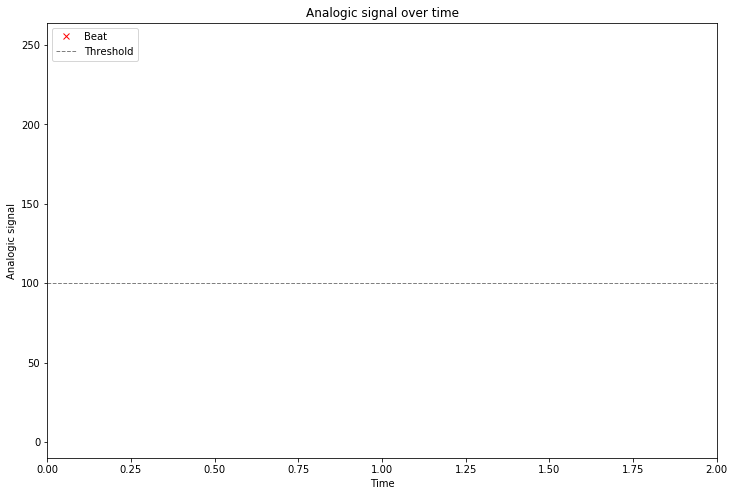

In [14]:
interval = 0.05 # seconds
time_window = 2 # Seconds

def init():
    line.set_data([],[])
    peak_point.set_data([], [])
    return (line, )

def animate(i):
    time = i * interval
    min_time = time - time_window
    dt = df[(df.Time >= min_time) & (df.Time <= time)].copy()
    dt.Time = dt.Time - min_time
    
    for index, row in dt.iterrows():
        peak = eval_peak(row.Speed)
        if peak:
            peak_point.set_data([row.Time], [peak])
    
    line.set_data(dt.Time, dt.Speed)
    return (line, )

plt.rcParams['figure.figsize'] = (12, 8)

fig, ax = plt.subplots()
ax.set_xlim((0, time_window))
max_y = df.Speed.max()
# ax.set_ylim((-10, 1024))
ax.set_ylim((-10, max_y))
peak_point, = ax.plot([], [], 'x', markersize=6, color='red', label='Beat', lw=0)
threshold_line, = ax.plot(
    [0, time_window], [threshold, threshold], 
    '--', 
    label='Threshold',
    color='grey', 
    lw=1
)
ax.legend(loc='upper left')
line, = ax.plot([], [], lw=2)
ax.set_title('Analogic signal over time')
ax.set_ylabel('Analogic signal')
ax.set_xlabel('Time');

In [15]:
anim = animation.FuncAnimation(
    fig,
    animate, 
    init_func=init,
    interval=80,
    frames=100,
    blit=True
)

HTML(anim.to_html5_video())